
# EDA & Comparison — UNSW-NB15 vs CICIDS2017

This notebook performs a **thorough exploratory data analysis (EDA)** on the two public intrusion datasets:
- **UNSW-NB15** (columns like `proto`, `service`, `state`, `spkts`, `dpkts`, ...)
- **CICIDS2017** (flow-based features like `Flow Duration`, `Flow Bytes/s`, `Fwd IAT Mean`, ...)

It standardizes a few **comparable engineered features** (duration, total packets/bytes, packets-per-second, bytes-per-second) so we can reason about both datasets side-by-side like a SOC analyst would.

> **How to use**  
> - Place this notebook inside your repo under `notebooks/`  
> - Make sure your raw data lives under `../data/raw/` relative to the notebook  
> - Run cells top-to-bottom. For CICIDS (very large), the notebook samples each file.


In [1]:

# --- Imports & setup ---
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import textwrap
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

# Matplotlib default style (no seaborn per project constraints)
plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.grid": True
})

RAW_DIR = Path("../data/raw")


## Helper functions

In [2]:

def load_unsw(raw_dir: Path) -> pd.DataFrame:
    """Load UNSW-NB15 from training/testing CSVs and concatenate."""
    train = raw_dir / "UNSW_NB15_training-set.csv"
    test = raw_dir / "UNSW_NB15_testing-set.csv"
    if not train.exists() or not test.exists():
        raise FileNotFoundError("UNSW files not found under ../data/raw/. Expected UNSW_NB15_training-set.csv and UNSW_NB15_testing-set.csv")
    df_tr = pd.read_csv(train)
    df_te = pd.read_csv(test)
    df = pd.concat([df_tr, df_te], ignore_index=True)
    # normalize column names (strip only; keep original naming)
    df.columns = df.columns.str.strip()
    return df


def load_cicids_sample(raw_dir: Path, nrows_per_file: int = 100_000, file_glob: str = "*.csv") -> pd.DataFrame:
    """Load CICIDS by sampling up to nrows_per_file from each CSV file, then concat.
    file_glob can be used to restrict files (e.g., 'Friday*.csv')."""
    files = sorted(raw_dir.glob(file_glob))
    if not files:
        raise FileNotFoundError(f"No CICIDS CSV files found in {raw_dir} with pattern {file_glob}")
    parts = []
    for f in files:
        try:
            dfp = pd.read_csv(f, nrows=nrows_per_file)
            dfp.columns = dfp.columns.str.strip()
            parts.append(dfp)
            print(f"[INFO] Loaded {f.name} -> {dfp.shape}")
        except Exception as e:
            print(f"[WARN] Skipping {f.name}: {e}")
    if not parts:
        raise RuntimeError("No CICIDS parts could be loaded.")
    return pd.concat(parts, ignore_index=True)


def sanitize_numeric(df: pd.DataFrame, exclude_cols=None) -> pd.DataFrame:
    """Replace inf with NaN then fill NaN with 0 for numeric columns."""
    exclude_cols = set(exclude_cols or [])
    num_cols = [c for c in df.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]
    X = df[num_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    df[num_cols] = X
    return df


def engineered_features_unsw(df: pd.DataFrame) -> pd.DataFrame:
    """Create comparable engineered features for UNSW.
    - duration_sec: 'dur' (already seconds)
    - total_pkts: spkts + dpkts
    - total_bytes: sbytes + dbytes
    - pkts_per_sec: total_pkts / duration_sec
    - bytes_per_sec: total_bytes / duration_sec
    """
    d = df.copy()
    d['duration_sec'] = d['dur'].clip(lower=1e-9)  # avoid div by zero
    d['total_pkts'] = d['spkts'].astype(float) + d['dpkts'].astype(float)
    d['total_bytes'] = d['sbytes'].astype(float) + d['dbytes'].astype(float)
    d['pkts_per_sec'] = d['total_pkts'] / d['duration_sec']
    d['bytes_per_sec'] = d['total_bytes'] / d['duration_sec']
    # Binary label
    if 'label' in d.columns:
        d['binary_label'] = d['label'].astype(int)
    else:
        d['binary_label'] = np.nan
    return d


def engineered_features_cicids(df: pd.DataFrame) -> pd.DataFrame:
    """Create comparable engineered features for CICIDS.
    - duration_sec: Flow Duration is in microseconds
    - total_pkts: Total Fwd Packets + Total Backward Packets
    - total_bytes: Total Length of Fwd Packets + Total Length of Bwd Packets
    - pkts_per_sec: use Flow Packets/s when available else total_pkts/duration_sec
    - bytes_per_sec: use Flow Bytes/s when available else total_bytes/duration_sec
    """
    d = df.copy()
    # Rename if there are leading/trailing spaces (we already stripped in loader)
    dur_col = "Flow Duration"
    fwd_pkts = "Total Fwd Packets"
    bwd_pkts = "Total Backward Packets"
    fwd_len = "Total Length of Fwd Packets"
    bwd_len = "Total Length of Bwd Packets"
    flow_pkts_s = "Flow Packets/s"
    flow_bytes_s = "Flow Bytes/s"

    # duration in seconds
    d['duration_sec'] = (d[dur_col].astype(float)).clip(lower=1.0) / 1_000_000.0  # at least 1 microsecond -> 1e-6 s; but clip at 1 for conservative div
    # totals
    d['total_pkts'] = d[fwd_pkts].astype(float) + d[bwd_pkts].astype(float)
    d['total_bytes'] = d[fwd_len].astype(float) + d[bwd_len].astype(float)

    # fallback computations (if columns exist but contain zeros, we still compute ratios)
    if flow_pkts_s in d.columns:
        d['pkts_per_sec_raw'] = d[flow_pkts_s].astype(float).replace([np.inf, -np.inf], np.nan)
    else:
        d['pkts_per_sec_raw'] = np.nan
    if flow_bytes_s in d.columns:
        d['bytes_per_sec_raw'] = d[flow_bytes_s].astype(float).replace([np.inf, -np.inf], np.nan)
    else:
        d['bytes_per_sec_raw'] = np.nan

    # Use raw if finite, else compute from totals/duration
    d['pkts_per_sec'] = d['pkts_per_sec_raw']
    mask = ~np.isfinite(d['pkts_per_sec'])
    d.loc[mask, 'pkts_per_sec'] = d.loc[mask, 'total_pkts'] / d.loc[mask, 'duration_sec'].replace(0, 1e-9)

    d['bytes_per_sec'] = d['bytes_per_sec_raw']
    mask2 = ~np.isfinite(d['bytes_per_sec'])
    d.loc[mask2, 'bytes_per_sec'] = d.loc[mask2, 'total_bytes'] / d.loc[mask2, 'duration_sec'].replace(0, 1e-9)

    # Binary label
    if 'Label' in d.columns:
        d['binary_label'] = (d['Label'] != 'BENIGN').astype(int)
    else:
        d['binary_label'] = np.nan

    # Clean up temp columns
    d.drop(columns=['pkts_per_sec_raw', 'bytes_per_sec_raw'], inplace=True, errors='ignore')
    return d


def basic_summary(df: pd.DataFrame, dataset_name: str, label_col: str) -> pd.DataFrame:
    """Return a one-row summary with basic dataset stats."""
    n_rows, n_cols = df.shape
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c]) and c != label_col]
    label_counts = df[label_col].value_counts(dropna=False).to_dict() if label_col in df.columns else {}

    return pd.DataFrame([{
        "dataset": dataset_name,
        "rows": n_rows,
        "cols": n_cols,
        "num_features": len(num_cols),
        "cat_features": len(cat_cols),
        "label_col": label_col,
        "label_counts": label_counts
    }])


def plot_bar(series, title: str, xlabel: str = "", ylabel: str = "count"):
    counts = series.value_counts()
    plt.figure()
    counts.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


def plot_hist(series, title: str, bins: int = 100, logx: bool = True, logy: bool = True):
    plt.figure()
    plt.hist(series.dropna().values, bins=bins)
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def corr_with_label(df: pd.DataFrame, numeric_cols, label_col: str) -> pd.Series:
    """Point-biserial correlation (Pearson with binary label)."""
    if label_col not in df.columns:
        return pd.Series(dtype=float)
    y = df[label_col].astype(float)
    corrs = {}
    for c in numeric_cols:
        try:
            corrs[c] = pd.Series(df[c]).astype(float).corr(y)
        except Exception:
            corrs[c] = np.nan
    return pd.Series(corrs).sort_values(ascending=False)


def top_corr_heatmap(df: pd.DataFrame, numeric_cols, top_k: int = 20, title: str = "Top-k correlation heatmap"):
    # select top-k by variance to keep computation reasonable
    var = df[numeric_cols].var().sort_values(ascending=False)
    top = list(var.head(top_k).index)
    C = df[top].corr().values
    plt.figure(figsize=(10, 8))
    im = plt.imshow(C, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(top)), top, rotation=90)
    plt.yticks(range(len(top)), top)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def suggest_redundant_features(df: pd.DataFrame, numeric_cols, thresh: float = 0.95):
    """Return a set of features to drop based on high pairwise correlation."""
    corr = df[numeric_cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > thresh)]
    return to_drop


## Load datasets

In [3]:

# --- Load UNSW ---
unsw = load_unsw(RAW_DIR)
print(f"[UNSW] shape={unsw.shape} columns={len(unsw.columns)}")
print(unsw.head(3))

# --- Load CICIDS (sample each CSV) ---
# Adjust nrows_per_file if you need smaller/faster EDA
cicids = load_cicids_sample(RAW_DIR, nrows_per_file=100_000, file_glob="*.csv")
print(f"[CICIDS] sample shape={cicids.shape} columns={len(cicids.columns)}")
print(cicids.head(3))


[UNSW] shape=(257673, 45) columns=45
   id       dur proto service state  spkts  dpkts  sbytes  dbytes         rate  sttl  dttl        sload  dload  sloss  dloss  sinpkt  dinpkt  sjit  djit  \
0   1  0.000011   udp       -   INT      2      0     496       0   90909.0902   254     0  180363632.0    0.0      0      0   0.011     0.0   0.0   0.0   
1   2  0.000008   udp       -   INT      2      0    1762       0  125000.0003   254     0  881000000.0    0.0      0      0   0.008     0.0   0.0   0.0   
2   3  0.000005   udp       -   INT      2      0    1068       0  200000.0051   254     0  854400000.0    0.0      0      0   0.005     0.0   0.0   0.0   

   swin  stcpb  dtcpb  dwin  tcprtt  synack  ackdat  smean  dmean  trans_depth  response_body_len  ct_srv_src  ct_state_ttl  ct_dst_ltm  ct_src_dport_ltm  \
0     0      0      0     0     0.0     0.0     0.0    248      0            0                  0           2             2           1                 1   
1     0      0      0   

## Sanitize values & engineer comparable features

In [4]:

# Clean infinities/NaN in place for numeric columns
unsw = sanitize_numeric(unsw, exclude_cols=['attack_cat', 'label'])
cicids = sanitize_numeric(cicids, exclude_cols=['Label'])

unsw_e = engineered_features_unsw(unsw)
cicids_e = engineered_features_cicids(cicids)

print(unsw_e[['duration_sec','total_pkts','total_bytes','pkts_per_sec','bytes_per_sec','binary_label']].head(3))
print(cicids_e[['duration_sec','total_pkts','total_bytes','pkts_per_sec','bytes_per_sec','binary_label']].head(3))


   duration_sec  total_pkts  total_bytes   pkts_per_sec  bytes_per_sec  binary_label
0      0.000011         2.0        496.0  181818.181818   4.509091e+07             0
1      0.000008         2.0       1762.0  250000.000000   2.202500e+08             0
2      0.000005         2.0       1068.0  400000.000000   2.136000e+08             0
   duration_sec  total_pkts  total_bytes  pkts_per_sec  bytes_per_sec  binary_label
0      0.000003         2.0         12.0  666666.66670   4.000000e+06             0
1      0.000109         2.0         12.0   18348.62385   1.100917e+05             0
2      0.000052         2.0         12.0   38461.53846   2.307692e+05             0


## Basic summaries

In [5]:

unsw_summary = basic_summary(unsw, "UNSW-NB15", "label")
cicids_summary = basic_summary(cicids, "CICIDS2017", "Label")
summary = pd.concat([unsw_summary, cicids_summary], ignore_index=True)
summary


,dataset,rows,cols,num_features,cat_features,label_col,label_counts
0,UNSW-NB15,257673,45,41,4,label,"{1: 164673, 0: 93000}"
1,CICIDS2017,982332,124,119,4,Label,"{'BENIGN': 680098, nan: 182332, 'DDoS': 61194,..."


## Label distributions & class imbalance

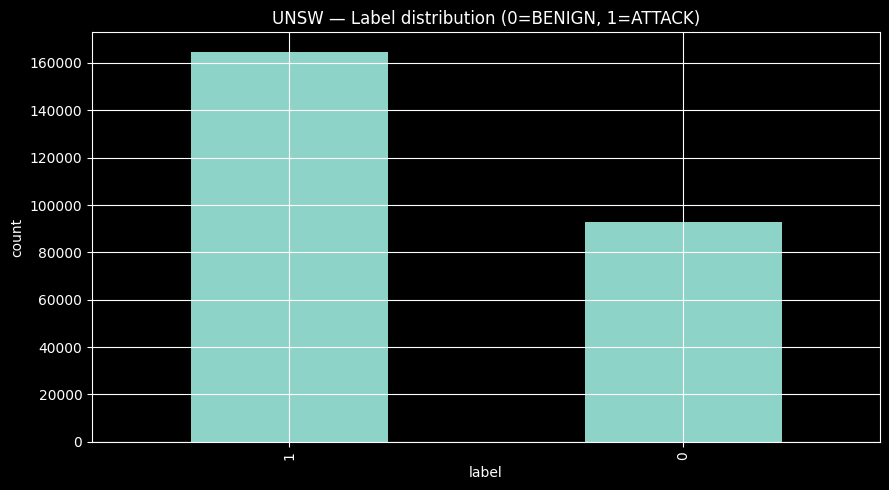

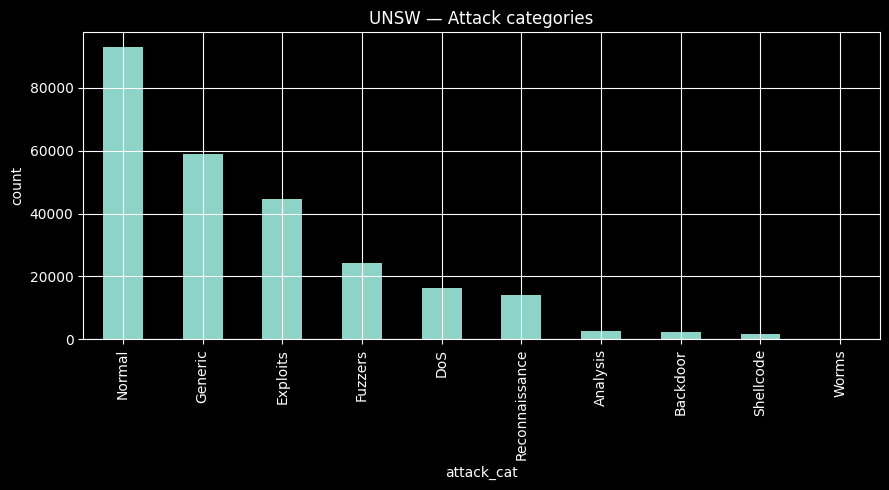

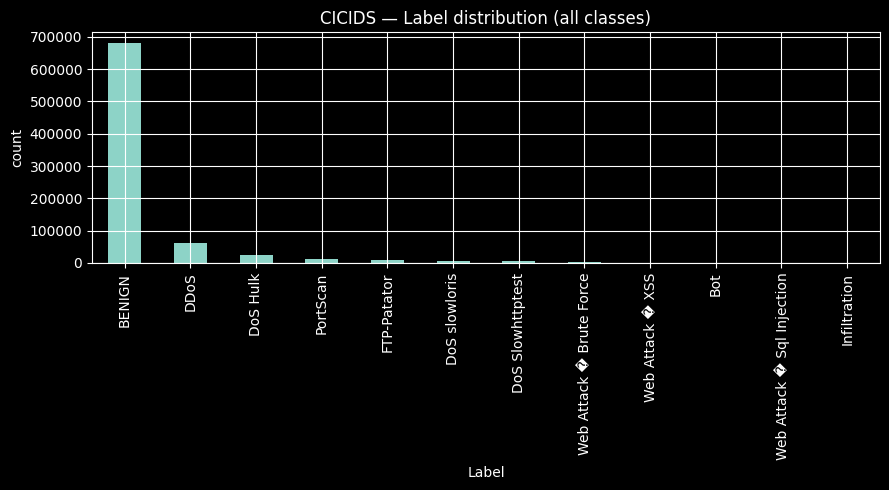

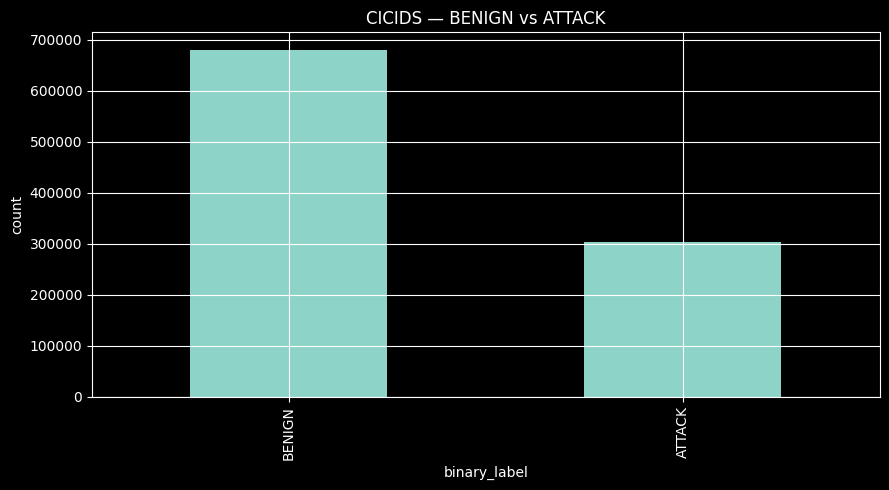

In [6]:

# UNSW: label 0/1 and attack_cat
plot_bar(unsw['label'], "UNSW — Label distribution (0=BENIGN, 1=ATTACK)", xlabel="label")
if 'attack_cat' in unsw.columns:
    plot_bar(unsw['attack_cat'], "UNSW — Attack categories", xlabel="attack_cat")

# CICIDS: many string labels; also make a binary view
plot_bar(cicids['Label'], "CICIDS — Label distribution (all classes)", xlabel="Label")
cicids_e['binary_label_str'] = cicids_e['binary_label'].map({0:"BENIGN",1:"ATTACK"})
plot_bar(cicids_e['binary_label_str'], "CICIDS — BENIGN vs ATTACK", xlabel="binary_label")


## Distributions of comparable engineered features

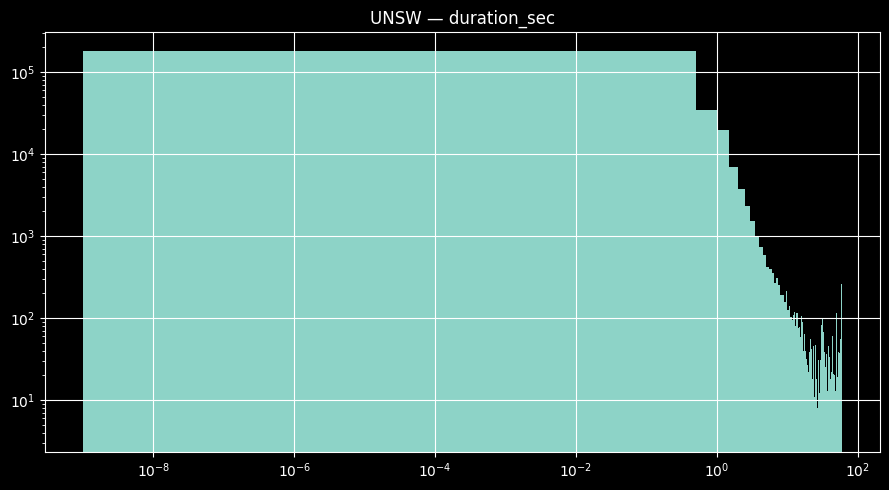

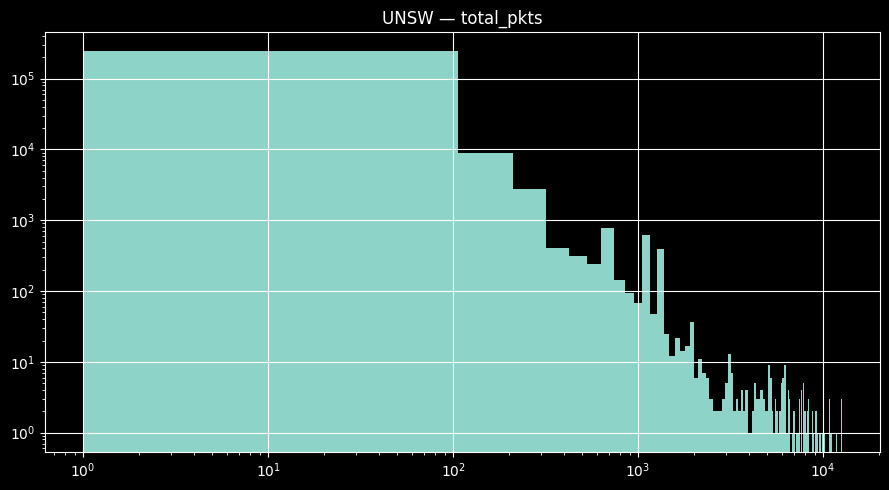

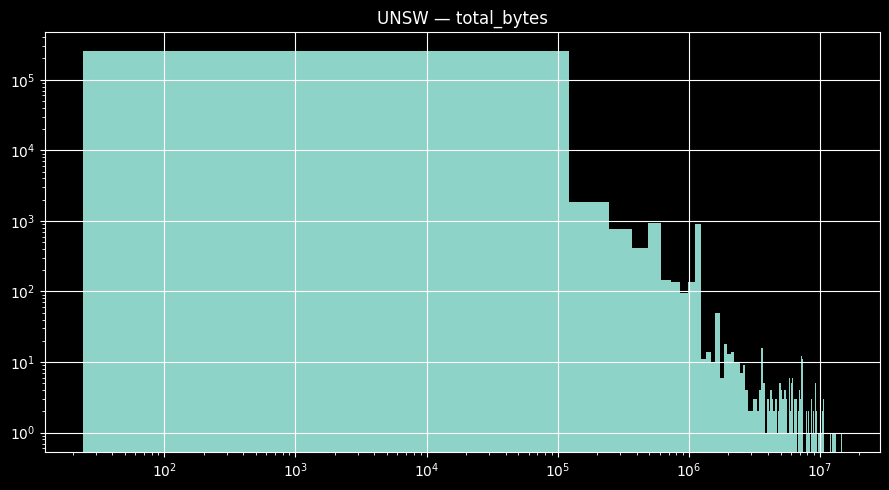

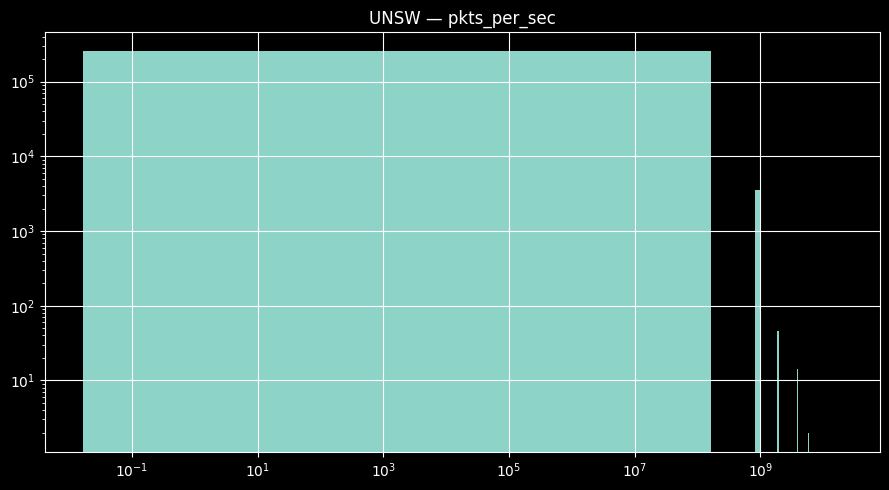

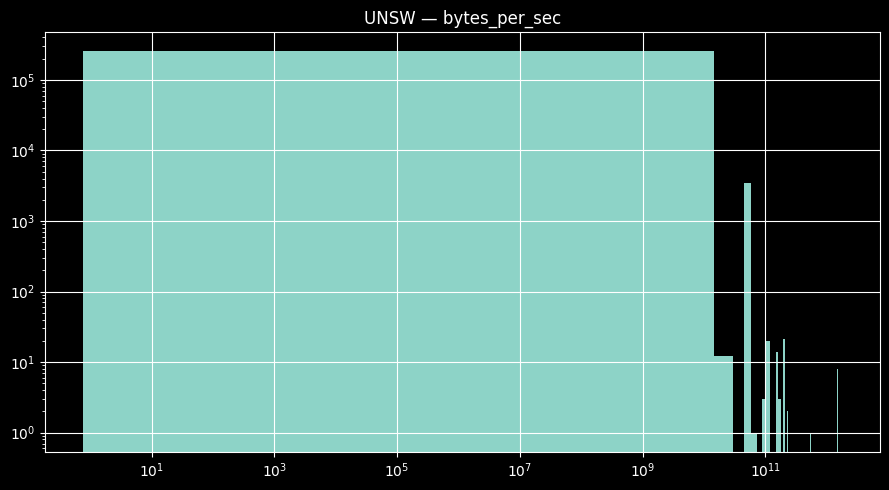

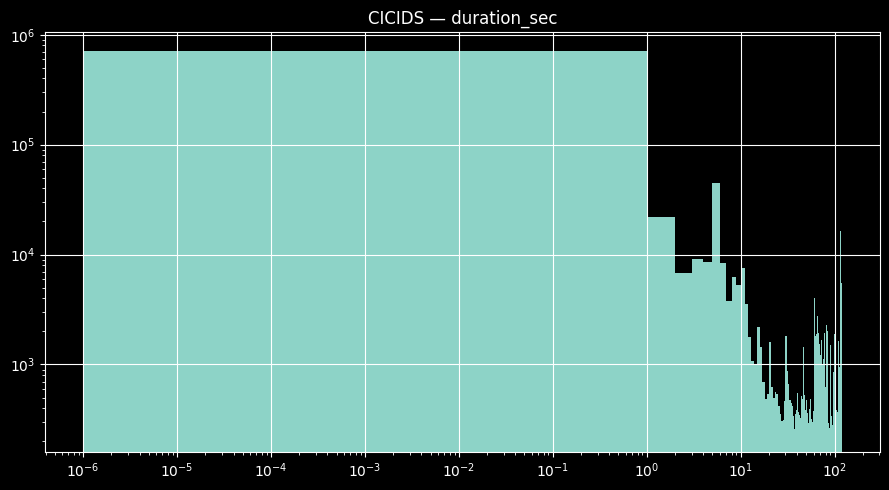

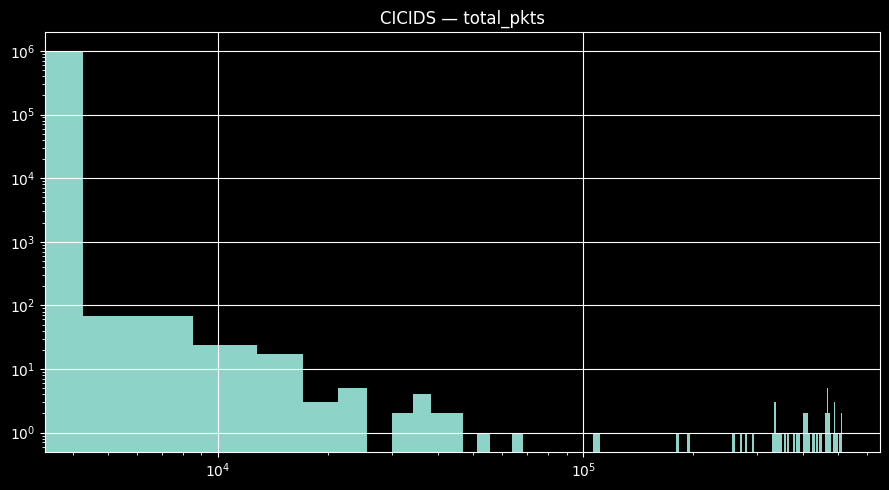

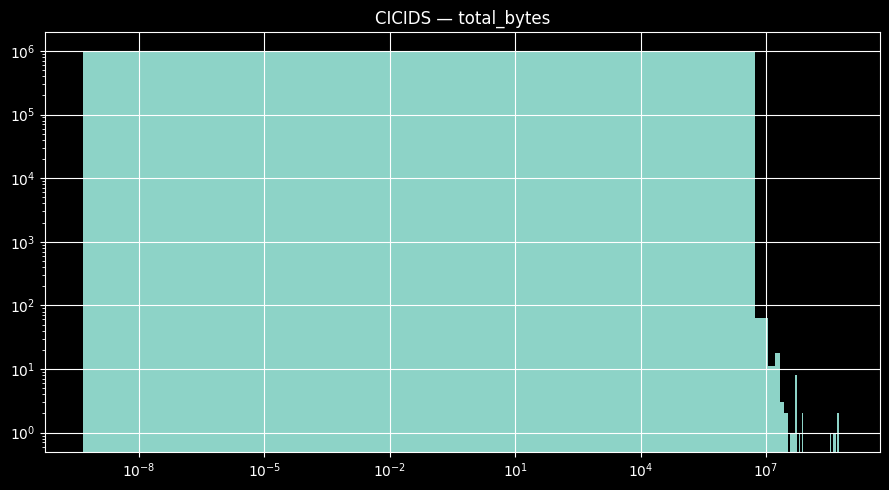

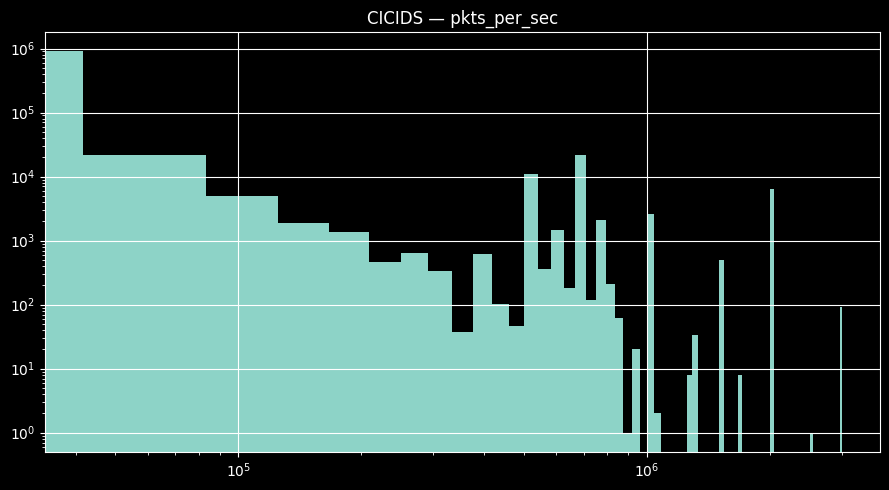

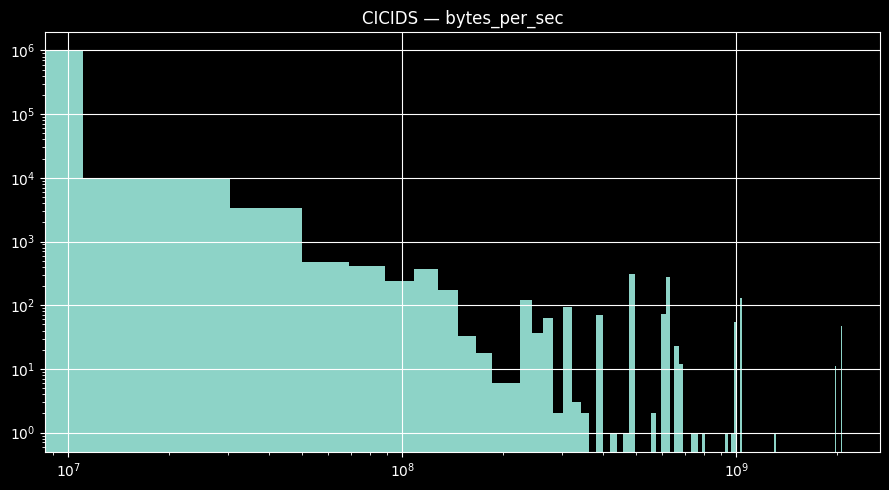

In [7]:

for col in ['duration_sec', 'total_pkts', 'total_bytes', 'pkts_per_sec', 'bytes_per_sec']:
    plot_hist(unsw_e[col], f"UNSW — {col}", bins=120, logx=True, logy=True)
for col in ['duration_sec', 'total_pkts', 'total_bytes', 'pkts_per_sec', 'bytes_per_sec']:
    plot_hist(cicids_e[col], f"CICIDS — {col}", bins=120, logx=True, logy=True)


## Correlation with label (point-biserial) & top-k heatmaps

Top 15 UNSW correlations with label:


sttl                0.624082
id                  0.490584
ct_state_ttl        0.476559
ct_dst_sport_ltm    0.371672
rate                0.335883
ct_src_dport_ltm    0.318518
ct_dst_src_ltm      0.299609
ct_src_ltm          0.252498
ct_srv_dst          0.247812
ct_srv_src          0.246596
ct_dst_ltm          0.240776
sload               0.165249
dur                 0.029096
duration_sec        0.029096
sbytes              0.019376
dtype: float64


Top 15 CICIDS correlations with label:


id                0.600079
sttl              0.575159
swin              0.518961
dwin              0.511944
ct_state_ttl      0.497721
label             0.485359
stcpb             0.437277
dtcpb             0.437092
dttl              0.431005
ct_srv_src        0.422635
ct_srv_dst        0.411458
ct_src_ltm        0.398856
smean             0.379792
ct_dst_ltm        0.370132
ct_dst_src_ltm    0.357421
dtype: float64

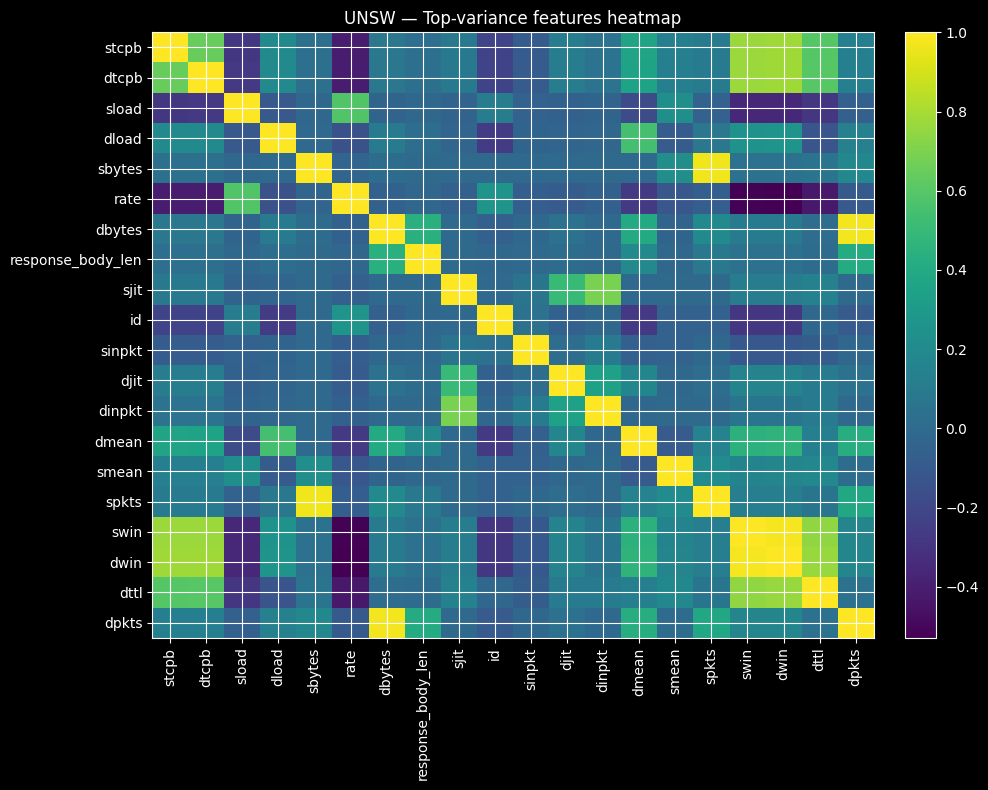

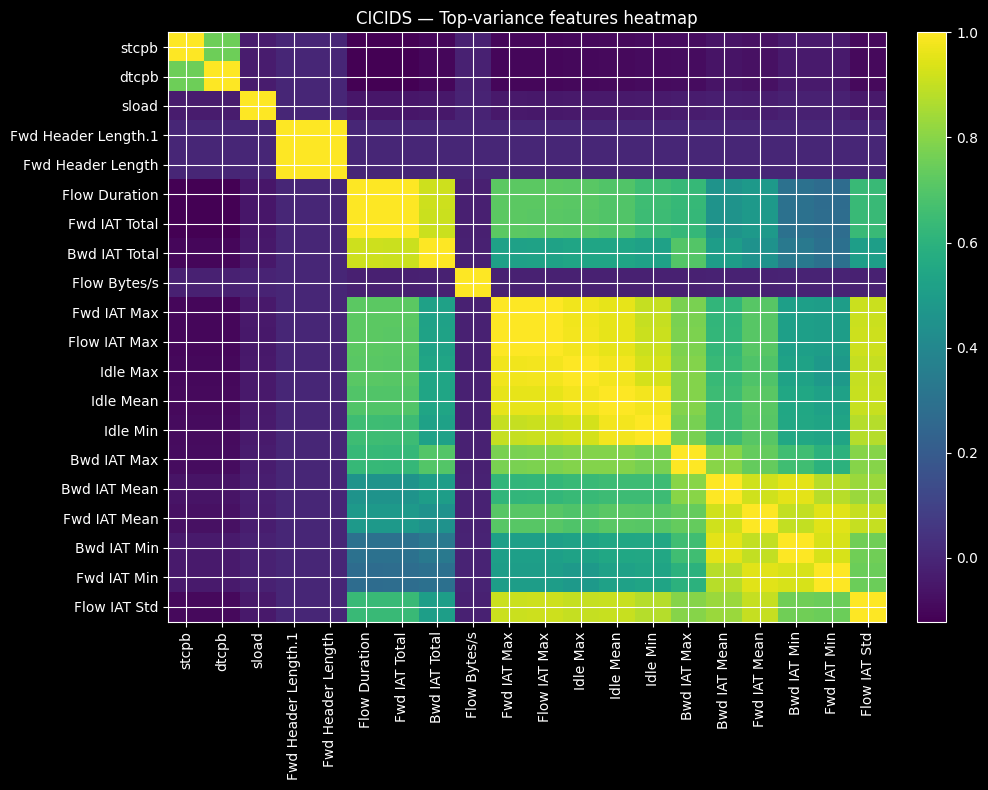

In [8]:

# Numeric columns (exclude labels/categories)
unsw_num = [c for c in unsw.columns if c not in ['attack_cat','label'] and pd.api.types.is_numeric_dtype(unsw[c])]
cicids_num = [c for c in cicids.columns if c != 'Label' and pd.api.types.is_numeric_dtype(cicids[c])]

# Add engineered comparable metrics to lists (if not already present in dataset)
for col in ['duration_sec','total_pkts','total_bytes','pkts_per_sec','bytes_per_sec']:
    if col not in unsw_e.columns: unsw_e[col] = np.nan
    if col not in cicids_e.columns: cicids_e[col] = np.nan

# Correlation with binary label
unsw_corr_label = corr_with_label(unsw_e, unsw_num + ['duration_sec','total_pkts','total_bytes','pkts_per_sec','bytes_per_sec'], 'binary_label')
cicids_corr_label = corr_with_label(cicids_e, cicids_num + ['duration_sec','total_pkts','total_bytes','pkts_per_sec','bytes_per_sec'], 'binary_label')

print("Top 15 UNSW correlations with label:")
display(unsw_corr_label.head(15))
print("\nTop 15 CICIDS correlations with label:")
display(cicids_corr_label.head(15))

# Heatmaps of top variance features
top_corr_heatmap(unsw_e, [c for c in unsw_num if c in unsw_e.columns], top_k=20, title="UNSW — Top-variance features heatmap")
top_corr_heatmap(cicids_e, [c for c in cicids_num if c in cicids_e.columns], top_k=20, title="CICIDS — Top-variance features heatmap")


## Redundant feature suggestion (|corr| > 0.95)

In [9]:

unsw_redundant = suggest_redundant_features(unsw, [c for c in unsw.columns if c not in ['attack_cat','label'] and pd.api.types.is_numeric_dtype(unsw[c])], thresh=0.95)
cicids_redundant = suggest_redundant_features(cicids, [c for c in cicids.columns if c != 'Label' and pd.api.types.is_numeric_dtype(cicids[c])], thresh=0.95)

print("UNSW redundant (candidate drop):", unsw_redundant[:30])
print("CICIDS redundant (candidate drop):", cicids_redundant[:30])


UNSW redundant (candidate drop): ['sbytes', 'dbytes', 'sloss', 'dloss', 'dwin', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_srv_dst']
CICIDS redundant (candidate drop): ['Total Backward Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Fwd IAT Total', 'Fwd IAT Max', 'Bwd IAT Min', 'Fwd Packets/s', 'Packet Length Std', 'SYN Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Idle Mean', 'Idle Max', 'Idle Min', 'sbytes', 'dbytes', 'sloss', 'dloss', 'dwin', 'ct_ftp_cmd']


## Outlier check (quantiles) on key comparable features

In [10]:

def quantile_table(df, cols, qs=[0.0, 0.5, 0.9, 0.99, 0.999, 1.0]):
    rows = []
    for c in cols:
        if c in df.columns:
            q = df[c].quantile(qs)
            rows.append(pd.Series(q, name=c))
    return pd.DataFrame(rows)

key_cols = ['duration_sec','total_pkts','total_bytes','pkts_per_sec','bytes_per_sec']
print("UNSW quantiles:")
display(quantile_table(unsw_e, key_cols))
print("\nCICIDS quantiles:")
display(quantile_table(cicids_e, key_cols))


UNSW quantiles:


,0.000,0.500,0.900,0.990,0.999,1.000
duration_sec,1.000000e-09,0.004285,1.470495e+00,3.785372e+01,5.995514e+01,5.999999e+01
total_pkts,1.000000e+00,8.000000,7.800000e+01,6.040000e+02,1.928000e+03,1.266000e+04
total_bytes,2.400000e+01,832.000000,2.631160e+04,5.075620e+05,2.080698e+06,1.472823e+07
pkts_per_sec,1.666906e-02,4032.258065,6.666667e+05,1.000000e+09,1.000000e+09,2.000000e+10
bytes_per_sec,7.667768e-01,770734.764217,5.000000e+07,4.600000e+10,4.600000e+10,1.768000e+12



CICIDS quantiles:


,0.000,0.500,0.900,0.990,0.999,1.000
duration_sec,1.000000e-06,0.030722,6.604296e+01,1.179241e+02,1.198325e+02,1.200000e+02
total_pkts,0.000000e+00,4.000000,2.300000e+01,1.190000e+02,8.470000e+02,5.116810e+05
total_bytes,0.000000e+00,164.000000,1.162700e+04,8.989918e+04,8.995645e+05,6.567764e+08
pkts_per_sec,-2.000000e+06,19.309726,2.985075e+04,8.125000e+05,2.000000e+06,3.000000e+06
bytes_per_sec,-2.610000e+08,779.665996,1.095890e+06,1.233333e+07,3.970000e+08,2.071000e+09



## 📌 Recommendations (as a starting point)

**UNSW-NB15**
- Likely relevant features (based on SOC semantics): `spkts`, `dpkts`, `sbytes`, `dbytes`, `rate`, `sinpkt`, `dinpkt`, `tcprtt`, `synack`, `ackdat`, counters like `ct_srv_src`, `ct_dst_ltm`, etc.
- Consider dropping highly redundant numeric pairs if any (see list above with |corr| > 0.95).
- Watch for severe class imbalance (`label` 0/1) — may need stratified sampling or class weights.

**CICIDS2017**
- Focus on flow features: `Flow Packets/s`, `Flow Bytes/s`, `Fwd/Bwd IAT` stats, TCP flag counts, `Active/Idle` stats.
- Replace infinities (e.g., in rate-like features) and sanitize NaNs before scaling (already handled in preprocessing).
- Because of dataset size, consider incremental/streaming preprocessing and subsampling for EDA.

**Comparable engineered metrics (for both)**
- `duration_sec`, `total_pkts`, `total_bytes`, `pkts_per_sec`, `bytes_per_sec` are useful to compare behavior across datasets and attack families.

> After EDA decisions (drops, transforms), reflect them in your `preprocess.py` so the training pipeline uses the same cleaned feature sets.
